In [1]:
%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 8

In [3]:
from kid_readout.measurement.io import nc

In [4]:
ncf = nc.NCFile('/data/readout/2016-07-12_122643_magnetic_shield.nc')

In [5]:
ncf_off = nc.NCFile('/data/readout/2016-07-12_160006_magnetic_shield_compressor_off.nc')

In [13]:
print(ncf.metadata.script_code)

"""
Record one SweepStreamArray for 3 resonators plus 1 dummy at each attenuation.
"""
import time

import numpy as np

from kid_readout.roach import r2baseband, analog
from kid_readout.measurement import acquire, basic
from kid_readout.equipment import hardware
from kid_readout.settings import ROACH2_IP, ROACH2_VALON
from kid_readout.equipment import starcryo_temps

acquire.show_settings()
logger = acquire.get_script_logger(__file__)

# Parameters
#all_f0_MHz = np.array([78.33, 90.80, 94.97, 104.35, 107.24, 116.11, 124.47, 125.81, 135.17, 138.35, 160.80])
#measured_indices = np.array([0, 5, 10])
#dummy_MHz = np.array([170])
#f0_MHz = np.concatenate((all_f0_MHz[measured_indices], dummy_MHz))
dummy_MHz = 170
f0_MHz = np.array([78.350, 116.164, 160.815, dummy_MHz])
attenuations = [35, 41, 47, 53]
tone_sample_exponent = 21  # The linewidth may be as small as 250 Hz.
sweep_length_seconds = 0.1
stream_length_seconds = 30
num_sweep_tones = 128

# Hardware
conditioner = analog.Baseband()
shie

In [6]:
ncf.node_names()

[u'SweepStreamArray0',
 u'ADCSnap1',
 u'SweepStreamArray2',
 u'ADCSnap3',
 u'SweepStreamArray4',
 u'ADCSnap5',
 u'SweepStreamArray6',
 u'ADCSnap7']

In [7]:
ssas = [ncf.read(name) for name in ncf.node_names() if name.startswith('SweepStreamArray')]

In [8]:
ssa_off = ncf_off.SweepStreamArray0

In [9]:
from collections import namedtuple
ResonatorData = namedtuple('ResonatorData', field_names=['f_data', 's21_data',
                                                         'f_model', 's21_model',
                                                         'f_r', 's21_r'])

def extract(resonator, normalize, num_model_points):
    f_data = resonator.frequency.copy()
    s21_data = resonator.data.copy()
    f_model = np.linspace(f_data.min(), f_data.max(), num_model_points)
    s21_model = resonator.model.eval(params=resonator.current_params, f=f_model)
    f_r = resonator.f_0
    s21_r = resonator.model.eval(params=resonator.current_params, f=f_r)
    if normalize:
        s21_data = resonator.remove_background(frequency=f_data, s21_raw=s21_data)
        s21_model = resonator.remove_background(frequency=f_model, s21_raw=s21_model)
        s21_r = resonator.remove_background(frequency=f_r, s21_raw=s21_r)
    return ResonatorData(f_data, s21_data, f_model, s21_model, f_r, s21_r)

    
def amplitude(axis, resonator, normalize=False, num_model_points=1000, f_scale=1e-6, three_ticks=True):
    rd = extract(resonator, normalize, num_model_points)
    ax.plot(f_scale * rd.f_data, 20 * np.log10(np.abs(rd.s21_data)), '.b', markersize=2)
    ax.plot(f_scale * rd.f_model, 20 * np.log10(np.abs(rd.s21_model)), '-', color='brown')
    ax.plot(f_scale * rd.f_r, 20 * np.log10(np.abs(rd.s21_r)), '.', color='brown', markersize=3)
    if three_ticks:
        ax.set_xticks(f_scale * np.array([rd.f_data.min(), rd.f_r, rd.f_data.max()]))

In [10]:
colors = ('b', 'g', 'r', 'k')

# Sweep data for three resonators

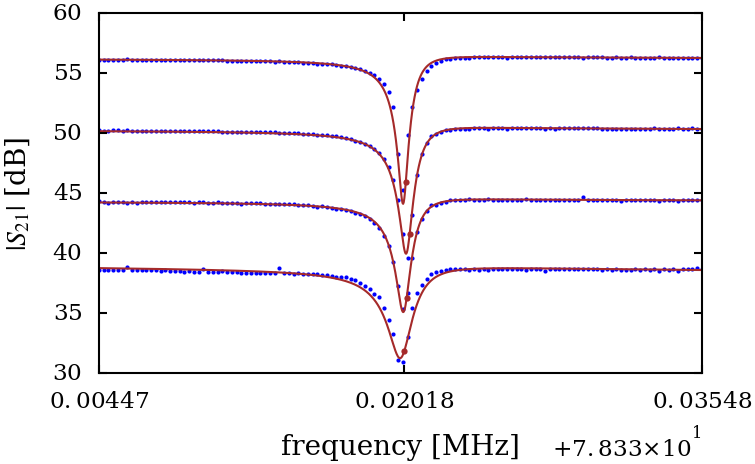

In [11]:
channel_index = 0

fig, ax = plt.subplots()
ax.set_xlabel('frequency [MHz]')
ax.set_ylabel('$|S_{21}|$ [dB]')

for ssa, color in zip(ssas, colors):
    ss = ssa[channel_index]
    amplitude(ax, ss.sweep.resonator, normalize=False)

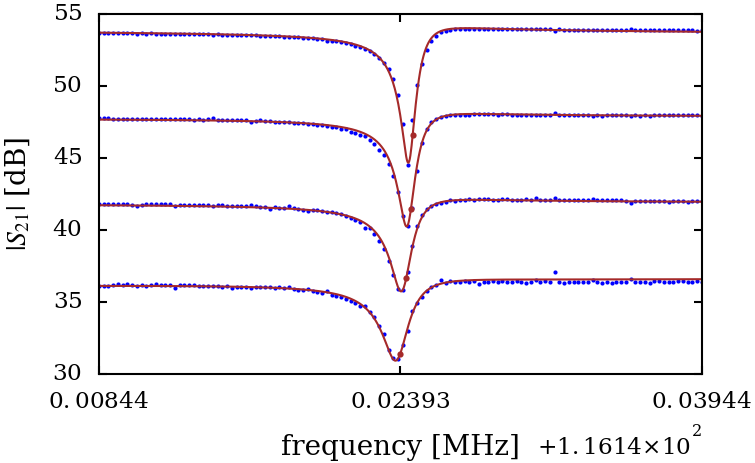

In [66]:
channel_index = 1

fig, ax = plt.subplots()
ax.set_xlabel('frequency [MHz]')
ax.set_ylabel('$|S_{21}|$ [dB]')

for ssa in ssas:
    ss = ssa[channel_index]
    amplitude(ax, ss.sweep.resonator)

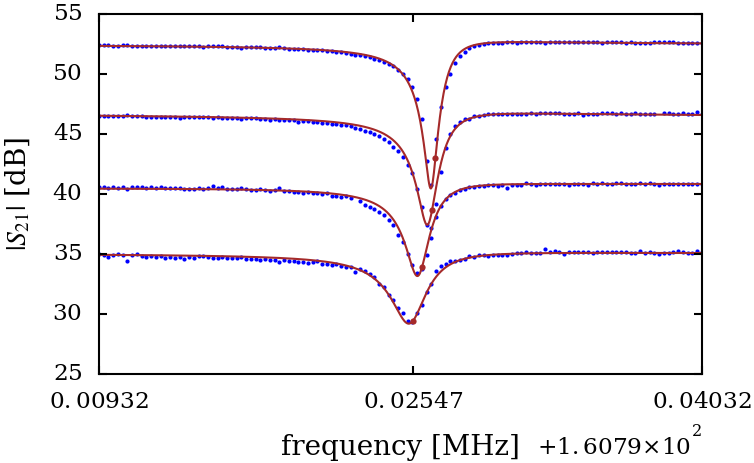

In [67]:
channel_index = 2

fig, ax = plt.subplots()
ax.set_xlabel('frequency [MHz]')
ax.set_ylabel('$|S_{21}|$ [dB]')

for ssa in ssas:
    ss = ssa[channel_index]
    amplitude(ax, ss.sweep.resonator)

# Dummy channel

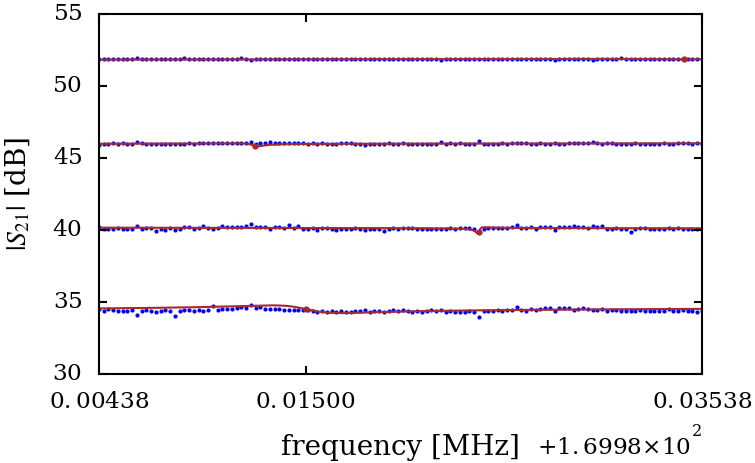

In [93]:
channel_index = 3

fig, ax = plt.subplots()
ax.set_xlabel('frequency [MHz]')
ax.set_ylabel('$|S_{21}|$ [dB]')

for ssa in ssas:
    ss = ssa[channel_index]
    amplitude(ax, ss.sweep.resonator)

# Quality factors

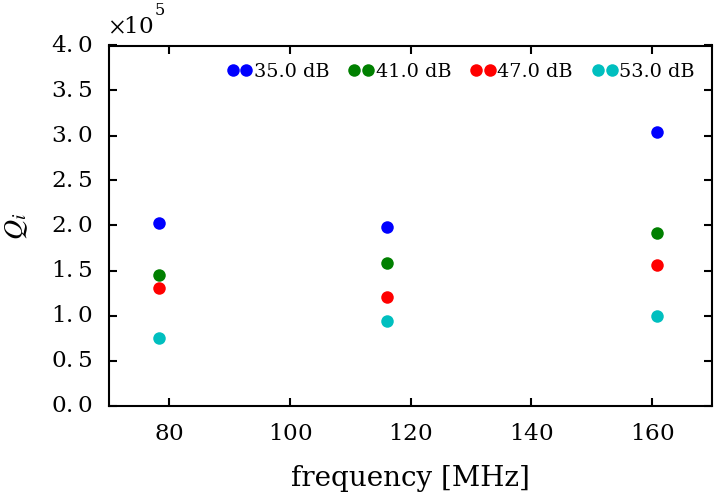

In [80]:
fig, ax = plt.subplots()

for ssa in ssas:
    f = np.array([1e-6 * ssa[n].sweep.resonator.f_0 for n in range(ssa.num_channels-1)])
    Qi = np.array([ssa[n].sweep.resonator.Q_i for n in range(ssa.num_channels-1)])
    Qc = np.array([ssa[n].sweep.resonator.Q_e_real for n in range(ssa.num_channels-1)])
    ax.plot(f, Qi, marker='o', linestyle='none', 
            label="{} dB".format(ssa.stream_array.roach_state.dac_attenuation))

ax.set_xlabel('frequency [MHz]')
ax.set_ylabel('$Q_i$')
ax.set_xlim(70, 170)
ax.set_ylim(0, 4e5)
ax.legend(loc='best', fontsize='xx-small', ncol=4);

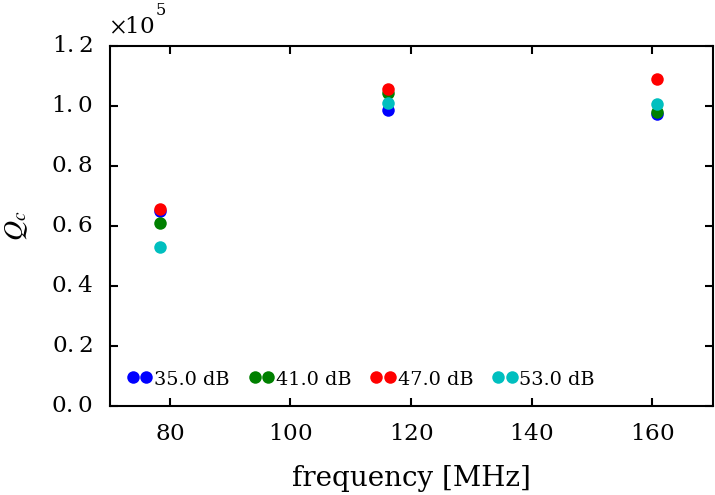

In [82]:
fig, ax = plt.subplots()

for ssa in ssas:
    f = np.array([1e-6 * ssa[n].sweep.resonator.f_0 for n in range(ssa.num_channels-1)])
    Qc = np.array([ssa[n].sweep.resonator.Q_e_real for n in range(ssa.num_channels-1)])
    ax.plot(f, Qc, marker='o', linestyle='none', 
            label="{} dB".format(ssa.stream_array.roach_state.dac_attenuation))

ax.set_xlabel('frequency [MHz]')
ax.set_ylabel('$Q_c$')
ax.set_xlim(70, 170)
ax.set_ylim(0, 1.2e5)
ax.legend(loc='best', fontsize='xx-small', ncol=4);

# Noise

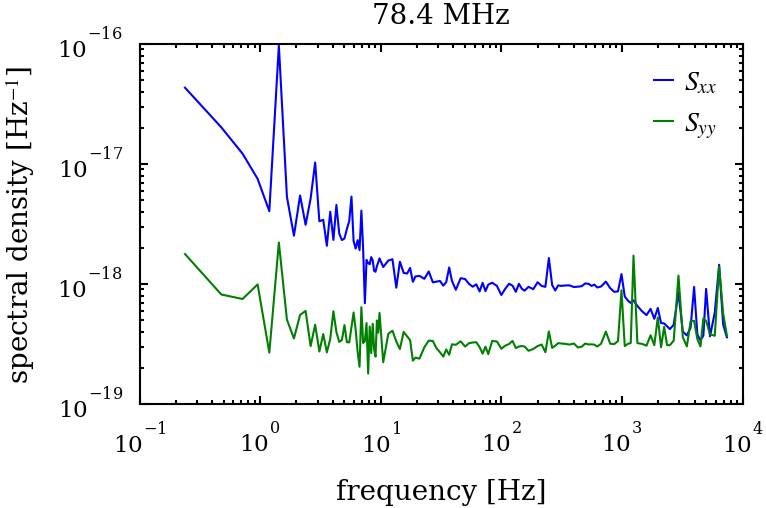

In [90]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

channel_index = 0
atten_index = 0

sss = ssas[atten_index][channel_index]
ax.plot(sss.S_frequency, sss.S_xx, label='$S_{xx}$')
ax.plot(sss.S_frequency, sss.S_yy, label='$S_{yy}$')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('spectral density [Hz$^{-1}$]')
ax.set_title('{:.1f} MHz'.format(1e-6 * sss.sweep.resonator.f_0))
ax.legend(loc='best', fontsize='small');

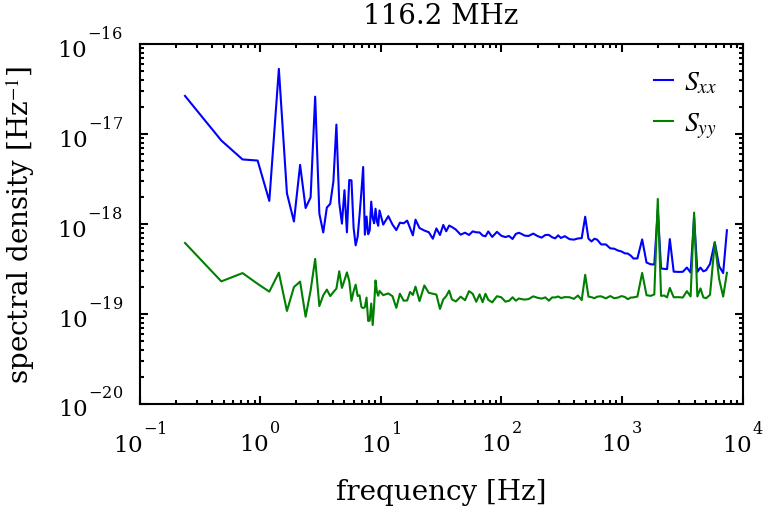

In [91]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

channel_index = 1
atten_index = 0

sss = ssas[atten_index][channel_index]
ax.plot(sss.S_frequency, sss.S_xx, label='$S_{xx}$')
ax.plot(sss.S_frequency, sss.S_yy, label='$S_{yy}$')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('spectral density [Hz$^{-1}$]')
ax.set_title('{:.1f} MHz'.format(1e-6 * sss.sweep.resonator.f_0))
ax.legend(loc='best', fontsize='small');

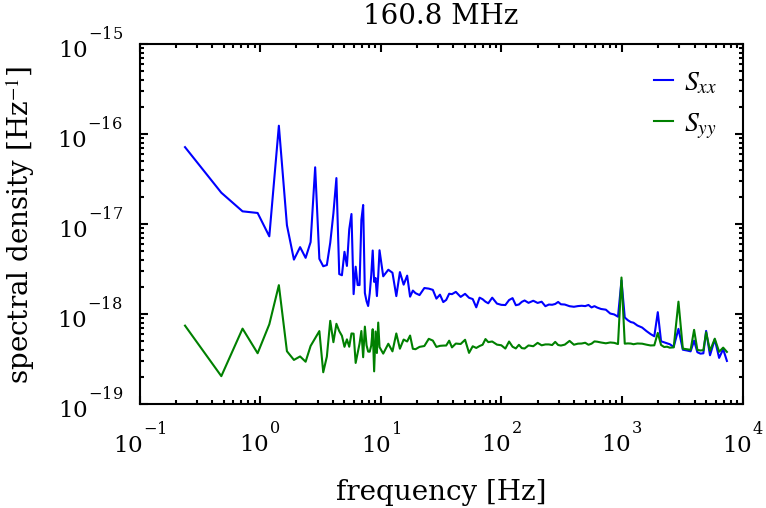

In [92]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

channel_index = 2
atten_index = 0

sss = ssas[atten_index][channel_index]
ax.plot(sss.S_frequency, sss.S_xx, label='$S_{xx}$')
ax.plot(sss.S_frequency, sss.S_yy, label='$S_{yy}$')

ax.set_title('{:.1f} MHz'.format(1e-6 * sss.sweep.resonator.f_0))
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('spectral density [Hz$^{-1}$]')
ax.legend(loc='best', fontsize='small');

# Compressor off

In [133]:
def detrend_poly(degree):
    def detrender(y):
        x = np.arange(y.size)
        return y - np.polyval(np.polyfit(x, y, degree), x)
    return detrender

detrend_quadratic = detrend_poly(2)
detrend_cubic = detrend_poly(3)

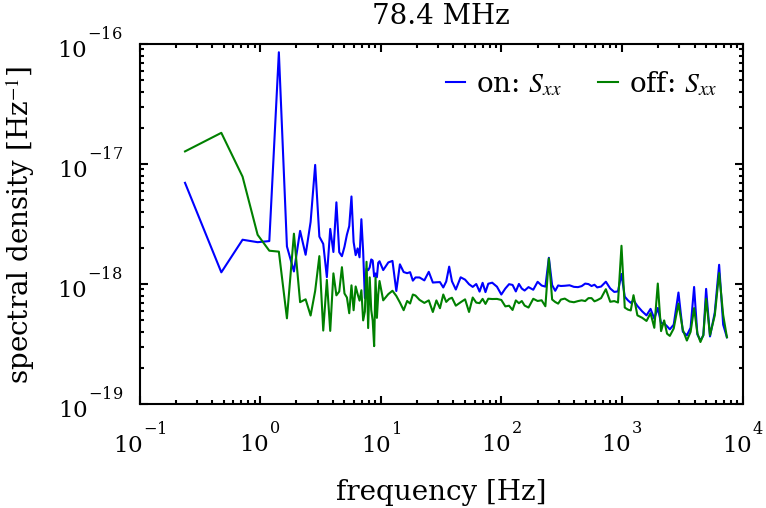

In [137]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

channel_index = 0
atten_index = 0

sss = ssas[atten_index][channel_index]
sss.set_S(detrend=detrend_quadratic, window=plt.mlab.window_none)

sss_off = ssa_off[channel_index]
sss_off.set_S(detrend=detrend_quadratic, window=plt.mlab.window_none)

ax.plot(sss.S_frequency, sss.S_xx, label='on: $S_{xx}$')
#ax.plot(sss.S_frequency, sss.S_yy, label='on: $S_{yy}$')
ax.plot(sss_off.S_frequency, sss_off.S_xx, label='off: $S_{xx}$')
#ax.plot(sss_off.S_frequency, sss_off.S_yy, label='off: $S_{yy}$')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('spectral density [Hz$^{-1}$]')
ax.set_title('{:.1f} MHz'.format(1e-6 * sss.sweep.resonator.f_0))
ax.legend(loc='best', fontsize='small', ncol=2);

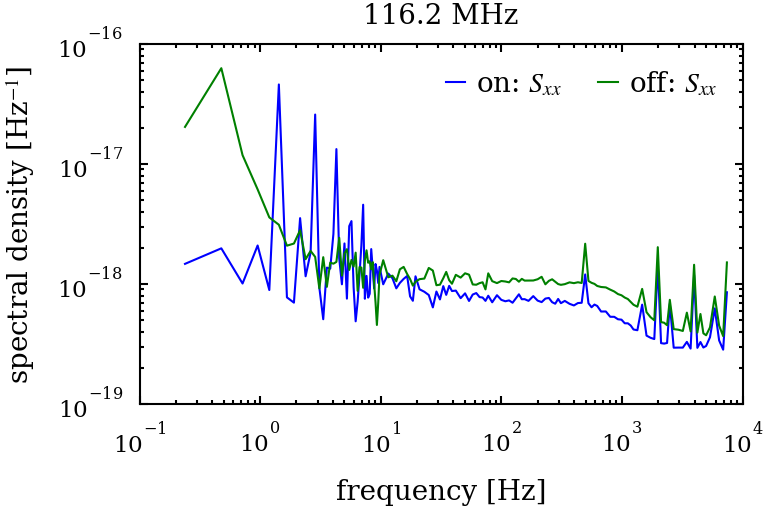

In [138]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

channel_index = 1
atten_index = 0

sss = ssas[atten_index][channel_index]
sss.set_S(detrend=detrend_quadratic, window=plt.mlab.window_none)

sss_off = ssa_off[channel_index]
sss_off.set_S(detrend=detrend_quadratic, window=plt.mlab.window_none)

ax.plot(sss.S_frequency, sss.S_xx, label='on: $S_{xx}$')
#ax.plot(sss.S_frequency, sss.S_yy, label='on: $S_{yy}$')
ax.plot(sss_off.S_frequency, sss_off.S_xx, label='off: $S_{xx}$')
#ax.plot(sss_off.S_frequency, sss_off.S_yy, label='off: $S_{yy}$')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('spectral density [Hz$^{-1}$]')
ax.set_title('{:.1f} MHz'.format(1e-6 * sss.sweep.resonator.f_0))
ax.legend(loc='best', fontsize='small', ncol=2);

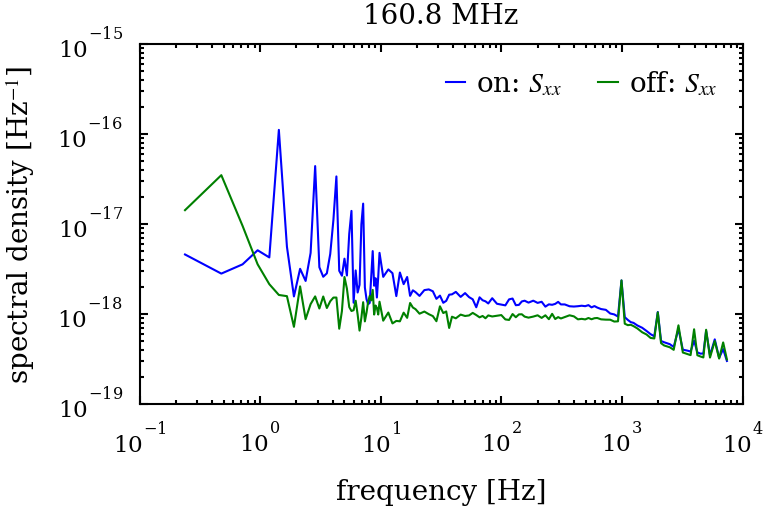

In [139]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

channel_index = 2
atten_index = 0

sss = ssas[atten_index][channel_index]
sss.set_S(detrend=detrend_quadratic, window=plt.mlab.window_none)

sss_off = ssa_off[channel_index]
sss_off.set_S(detrend=detrend_quadratic, window=plt.mlab.window_none)

ax.plot(sss.S_frequency, sss.S_xx, label='on: $S_{xx}$')
#ax.plot(sss.S_frequency, sss.S_yy, label='on: $S_{yy}$')
ax.plot(sss_off.S_frequency, sss_off.S_xx, label='off: $S_{xx}$')
#ax.plot(sss_off.S_frequency, sss_off.S_yy, label='off: $S_{yy}$')

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('spectral density [Hz$^{-1}$]')
ax.set_title('{:.1f} MHz'.format(1e-6 * sss.sweep.resonator.f_0))
ax.legend(loc='best', fontsize='small', ncol=2);

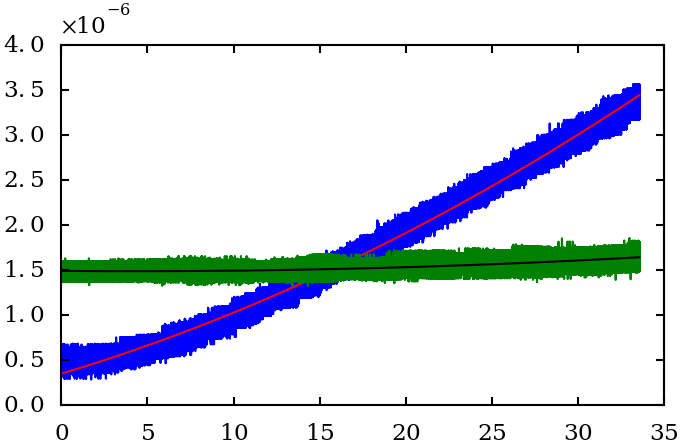

In [140]:
fig, ax = plt.subplots()

ax.plot(sss_off.stream.sample_time, sss_off.x)
x_poly = np.polyfit(x=sss_off.stream.sample_time, y=sss_off.x, deg=2)
ax.plot(sss_off.stream.sample_time, np.polyval(x_poly, sss_off.stream.sample_time), '-r')

ax.plot(sss_off.stream.sample_time, sss_off.y)
y_poly = np.polyfit(x=sss_off.stream.sample_time, y=sss_off.y, deg=2)
ax.plot(sss_off.stream.sample_time, np.polyval(y_poly, sss_off.stream.sample_time), '-k')